<center><h3><b><u> Multilayer Perceptron with MNIST Dataset</u></b></h1></center>

##### __Importing Libraries, Classes, and Functions__

In [105]:
import numpy as np
import torch
import torch.nn as nn #provides classes/modules for making neural networks
import torch.nn.functional as F #a module with common nn functions (operations on tensors/high dim matrices; activations)
import torch.optim as optim #contains SGD (Stochastic gradient descent)
from torchvision import datasets, transforms #includes MNIST
from torch.utils.data import DataLoader #allows shuffling and minbatches
from torch.nn import Linear
from PIL import Image
import matplotlib.pyplot as plt

##### __The Model Blueprint__

In [78]:
#Create a NN class that encapsulates all components of NN, instantiate later
# with __call__ object name can be treated as function that calls certain function in class (predefine)
#inherits from nn.Module class; many classes for different layers
class SimpleNN(nn.Module): 
    def __init__(self):
        super(SimpleNN, self).__init__() #explicitly call parent class constructor to initialize stuff
                                    #parent technically initialized too and tied to child but you only access child
        self.fc1 = Linear(28**2, 128) #first fully connected layer has 784 input neurons (performs matrix mult to calculate z)
                                 #next layer has 16 neurons
        self.fc2 = Linear(128, 64)
        self.fc3 = Linear(64, 10)
    
    def forward(self, pixels):
        '''MNIST is (batch_size = ..., channels = 1, height = 28, width = 28)
        Fully connected layers expect input tensors to be (batch_size, num_features); labels already liked this
        is actually multiplied by a vector (to get the weighted sum)
        Size of first dimension of tensor is batch size, -1 infers dim of the vector/features (784)
        Reshapes mini-batch into 2D tensor whre each row is image and column is flattened version
        Often need to flatten into fewer dimensions'''
        pixels = pixels.view(-1, 28**2) #(batch size dimension, other flattened dimension size)
        
        pixels = F.relu(self.fc1(pixels))  # Apply ReLU activation
        pixels = F.relu(self.fc2(pixels))  # Apply ReLU activation
        pixels = self.fc3(pixels)  # Output layer (logits)
        return pixels
    
#Instantiate model
model = SimpleNN()

#Loss function
mse = nn.CrossEntropyLoss() #making instance of this class to use the functions in it

#Other optimizers than SGD like Adam, takes momentum into account for adaptive learning rate: .05 good for SGD
optimizer = optim.SGD(model.parameters(), lr = 0.05) #iterable (like list) of parameters passed to optimizer

'''transformation function object: applies transformations in list sequentially; images into tensors -> normalize
normalize transforms the pixel values more condensed/similar so training is faster
Normalizing for single channel (good practice to include tuple instead of scalar even if only one channel)'''
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

#Load MNIST
train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform)

#creates iterator that provides batches of data during training
#the batches are in form of (image, label) tuple which are just tensors/vectors
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

#Adds batch size to image tensor in train loader
test_dataset = datasets.MNIST(root = './data', train = False, download = True, transform = transform)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

##### __Training__

In [38]:
'''Each parameter has its own special tensor (created per layer) 
with a number for its partial derivative in .grad attribute of tensor; step() accesses these'''

#Hyperparameter
num_epochs = 5

for epoch in range(num_epochs): #will do training cycle 5 times

    #each iteration is one minibatch of images/labels
    for images, labels in train_loader: 
        optimizer.zero_grad() #zeroing out gradient ignores .grad and recalculates partials in backprop
        outputs = model(images) #passes this to forward

        #numclasses is components; ex. 4 = [0,0,0,1,0,0,...]
        target = F.one_hot(labels, num_classes=10).float()
    
        loss = mse(outputs, target)
        loss.backward() #backward propogation to compute gradiaent
        optimizer.step() #updates model parameters (takes "step")
    
    #single number tensors converted to normal number with .item(); 4 decimal places as floating point number
    print(f'Epoch {epoch + 1}, Loss: {loss.item(): .4f}')

#Saves these parameters
'''Model has state dictionary, a Python dictionary that maps to the weights and biases. Extracts this
and stores it in a file with .pth convention by convention to store PyTorch parameters or entire models. Now
that it is written to disk, the model does not need to be retrained everytime to get parameters. The matrix
contains a weight matrix and bias vector for each layer.'''
torch.save(model.state_dict(), 'model.pth')

Epoch 1, Loss:  0.3972
Epoch 2, Loss:  0.0898
Epoch 3, Loss:  0.1087
Epoch 4, Loss:  0.0269
Epoch 5, Loss:  0.0092


##### __Saving and Loading the Model__

In [79]:
def load_model():
    # Instantiate the model
    model = SimpleNN()
    
    #Update model's parameters to what it was after training
    model.load_state_dict(torch.load('model.pth'))
    
    model.eval()
    
    return model

model = load_model()

##### __Evalulating/Testing the Model__

In [139]:
'''Sometimes in training some neurons turned off (called dropout) to prevent overfitting, but when testing 
you want all neurons in model to be used, so eval fixes this as well as other settings for testing so model
acts "normally"'''
model.eval()

#Counters
correct = 0
total = 0

'''with - disable gradient discent for the for loop and enable when for loop ends
Don't store unnecessary numbers (eg. intermediate activations) for calculating gradient; 
Saves memory and its faster
'''
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        
        #Return two tensors for max values (brightest neurons) and their indices
        '''
        Functions in Python can return multiple values by returning tuple which is extracted
        outputs.data dimensions are (batch_size, num_classes)
        Each row of outputs.data is list of outputs from each output neuron (1 per class) per training example
        For SGD outputs.data will 2D array, where all arrays/rows make mini-batch
        max has 2D tuple (2 outputs): the max values in each row and the indices of the outputs
        We don't care about the output number, just the index/number it predicted, so convention is to store 
        unimportant stuff in _
        Second output returns index of highest activation, the predicted class (same as number in this case)
        0th dimension is batch size; 1 as input means find max along dimension 1 (2nd dimension, # of classes/output neurons)
        predicted tensor components are each index of highest activation/predicted number; 
        component for label is correct index for each sample in the mini batch
        '''
        _, predicted = torch.max(outputs.data, 1)

        #Update Counters
        total += labels.size(0) #size of first dimension (batch size)

        #Compare each each tensor, which returns new tensor with each componenet being True or False
        #Sum counts the amount of True in the tensor
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {(correct/total) * 100: .2f}')

Test Accuracy:  96.67


##### __Inputting a New Image__

In [141]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

def pixelate_image(image, pixelation_level):
    # Load the image from the given path
    
    '''/ is floor division. Tuples have indices. Resize is changing # of pixels after knowing new 
    size of image, what makes it appear pixelated is then enlarging image so the few pixels are larger.
    Bilinear interpoloation is to get value of each pixel, look at weighted average of 4 nearest pixels 
    of where it would go to determine new value. Weighted based on what is closest to it. Then split those 
    big pixels up again so the size is same as original but looks more pixelated.'''

    new_size = (image.size[0] // pixelation_level, image.size[1] // pixelation_level)
    pixelated = image.resize(new_size,resample=Image.BILINEAR)

    pixelated = pixelated.resize((28, 28))
    
    return pixelated

#Preprocess using functions of the Image class
def preprocess_image(image_path):
    image = pixelate_image(image_path, 8)
    image = transform(image)  #Make it a tensor then normalize
    image = image.unsqueeze(0)  #Add another dimension (batch_size) to image; not used, but specific shape necessary
    return image

# Load and preprocess the image 
image = Image.open("2.png").convert('L') #"instantiating", gives size as attribute in tuple

pixelated_image_visual = pixelate_image(image, 8)

image_transformed = preprocess_image(image)


# Disable gradient computation for speedup
with torch.no_grad():
    output = model(image_transformed)
    _, predicted = torch.max(output.data, 1)

print(f'Predicted number: {predicted.item()}')

Predicted number: 2


##### __Visualizing the Transformed Image__

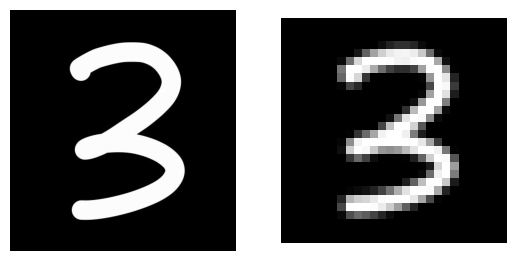

In [137]:
plt.subplot(1,2,1) #create subplot first
plt.imshow(image, cmap='gray')
plt.axis('off')

#dimensions need to be correct
plt.subplot(1,2,2)
plt.imshow(pixelated_image_visual, cmap='gray')
plt.axis('off') 

plt.show() #not need for Jupyter